# Twitter Data Analysis

## Setup

In [139]:
import sys 
sys.path.append("../")

In [140]:
from itertools import chain 
from collections import Counter 

In [141]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud

import pickle as pkl

In [142]:
# libraries for topic modeling

from gensim.models import LdaModel
from gensim import corpora

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [143]:
from lib.preprocessing.tweets import clean_tweet 
from lib.preprocessing.text import (
    tokenize, 
    remove_punctuation, 
    remove_stopwords, 
    stem
)

## Dataset

### Load tweets & classifier

Here we import the manually annotated dataset, the embeddings as well as the best classifier trained in the [tw-classification](notebooks/tw-classification.ipynb) notebook. Since only 1,000 tweets has been manually annotated, the goal is to use the classifier in order to identify price-related tweets in the remanining tweets.  

In [144]:
data_path = "../backup/data/df_annotated.csv"
df = pd.read_csv(data_path)

# convert date to datetime object 
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [145]:
df.head()

,timestamp,text,emojis,retweets,likes,comments,lexical_field,text_emojis,label
0,2020-01-01,le tout vendu à des prix \n«défiant toute conc...,NaN,NaN,NaN,NaN,cheap,NaN,NaN
1,2020-01-01,Pour ceux qui veulent allier l'utile à l'agréa...,🛑 🛑,NaN,NaN,NaN,cheap,Pour ceux qui veulent allier l'utile à l'agréa...,NaN
2,2020-01-02,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,3.0,NaN,NaN,cheap,NaN,not_about_prices
3,2020-01-02,J'ai du mal à savoir si #Cirelli a reçu la Leg...,NaN,3.0,1.0,NaN,cheap,NaN,NaN
4,2020-01-06,Un iPhone pas cher ? C’est maintenant possible...,⭐ 😉,284.0,69.0,36.0,cheap,Un iPhone pas cher ? C’est maintenant possible...,NaN


In [146]:
clf_path = "../backup/models/xgb_model.pkl"

with open(clf_path, "rb") as f: 
    clf = pkl.load(f)

embeddings_path = "../backup/data/embeddings.npy"
embeddings = np.load(embeddings_path)

print(f"Dimension of each embedding: {embeddings.shape[1]}")

Dimension of each embedding: 384


In [147]:
# check whether the embeddings and dataset are equal length
assert embeddings.shape[0] == df.shape[0]

The annotated dataset contains the `label` column which consists in 6 categories. One can notice very few observations for categories that are not "not_about_prices" or "inflation". It is decided to create the `on_topic` variable which is 1 if the tweet is related to prices (inflation, deflation, etc.), 0 otherwise.

Note we only apply the transformation on tweets that have been manually annotated.

In [148]:
df["label"].value_counts()

not_about_prices    684
inflation           302
desinflation         14
other                11
deflation             5
stability             2
Name: label, dtype: int64

In [149]:
def add_on_topic_variable(label: str) -> int: 
    """Description. Indicate whether tweet is about prices or not."""
    if label == "not_about_prices": 
        return 0 
    else: 
        return 1

# get annotated row indices
annotated_idxs = df.loc[df.label.notna(), :].index.tolist()

df.loc[
    df.index.isin(annotated_idxs),
    "on_topic"
] = df.loc[
    df.index.isin(annotated_idxs), 
    "label"
].apply(add_on_topic_variable)

In [150]:
df["on_topic"].value_counts()

0.0    684
1.0    334
Name: on_topic, dtype: int64

Before predicting using the `XGBClassifier` model, it is important to distinguish already-annoated tweets from those to label. 

In [151]:
idxs_to_label = df.loc[df.label.isna(), :].index.to_list()

print(f"{len(idxs_to_label)} tweets to label")

91943 tweets to label


In [152]:
X = embeddings[idxs_to_label, :]
predicted_labels = clf.predict(X)

We finally add the predicted labels to the partially annotated dataset. 

In [153]:
df.loc[df.index.isin(idxs_to_label), "on_topic"] = predicted_labels

It seems interesting to check the consistency of the predictions outputed by the `XGBClassifier` by selecting random tweets and verify whether they are about prices.

In [154]:
ix = np.random.choice(a=idxs_to_label)

tweet = df["text"][ix]
on_topic = bool(df["on_topic"][ix])
print(tweet)
print(f"{on_topic=}")

6 ans de plus pour Josh Allen avec les Bills
Buffalo Bills
@BuffaloBills
·
6 Aug 2021
We’ve agreed to terms with QB Josh Allen on a six-year extension through 2028 #BillsMafia 

Details: http://bufbills.co/3lEIJy0
1
8
on_topic=False


The resulting dataset is made up of about 25% of tweets related to prices matter.

In [155]:
df["on_topic"].value_counts() / df.shape[0]

0.0    0.733103
1.0    0.266897
Name: on_topic, dtype: float64

We thus select the observations for which the `on_topic` variable is equal to 1 and duplicates are also removed.

In [156]:
df_prices = df.loc[df.on_topic==1, :]
print(f"{len(df_prices)} rows after filtering prices-related tweets")

df_prices = df_prices.drop_duplicates(subset=["text"])
print(f"{len(df_prices)} rows after removing duplicates")

24811 rows after filtering prices-related tweets
24312 rows after removing duplicates


In [157]:
tweets = df_prices["text"].tolist()
n_tweets = len(tweets)

print(f"{n_tweets} unique tweets in the dataset.")

24312 unique tweets in the dataset.


## Text preprocessing

1. Remove tweet attributes (mentions, links, etc.)

In [158]:
tweets_cleaned = [clean_tweet(tweet) for tweet in tweets]

In [159]:
ix = np.random.randint(low=0, high=n_tweets)

print(f"Before cleaning:\n{tweets[ix]}")
print(f"\n\nAfter cleaning:\n{tweets_cleaned[ix]}")

Before cleaning:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC
3
8
24


After cleaning:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC


2. Tokenization

In [160]:
tweets_tokenized = [tokenize(tweet) for tweet in tweets_cleaned]

In [161]:
print(f"Before cleaning & tokenization:\n{tweets[ix]}")
print(f"\n\nAfter cleaning & tokenization:\n{tweets_tokenized[ix]}")

Before cleaning & tokenization:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC
3
8
24


After cleaning & tokenization:
['que', 'dieu', 'vienne', 'en', 'aide', 'à', 'toutes', 'ces', 'personnes', 'payées', 'en', 'francs', 'et', 'qui', 'malgré', 'l', '’', 'inflation', 'du', 'moment', ',', 'ne', 'sont', 'pas', 'augmentées', '.', '1', '$=', '1900fc', '?', 'c', '’', 'est', 'de', 'la', 'folie', '...', '#', 'rdc']


3. Remove punctuation and stopwords

In [162]:
tweets_no_punc = [remove_punctuation(tokens) for tokens in tweets_tokenized]

In [163]:
tweets_no_stopwords = [remove_stopwords(tokens) for tokens in tweets_no_punc]

In [164]:
print(f"Before full cleaning:\n{tweets[ix]}")
print(f"\n\nAfter full cleaning:\n{tweets_no_stopwords[ix]}")

Before full cleaning:
Que Dieu vienne en aide à toutes ces personnes payées en francs et qui malgré l’inflation du moment, ne sont pas augmentées. 1$=1900fc? C’est de la folie... #RDC
3
8
24


After full cleaning:
['dieu', 'vienne', 'aide', 'personnes', 'payées', 'francs', 'inflation', 'moment', 'pas', 'augmentées', '1', '1900fc', 'folie', 'rdc']


4. Update dataset 

- Add preprocessed tweets
- Add number of tokens per tweet

In [165]:
df_prices.loc[:, "tokens"] = np.array(tweets_no_stopwords, dtype=object) 
df_prices.loc[:, "n_tokens"] = df_prices.loc[:, "tokens"].apply(len)

## Data visualisation

### Tweet statistics

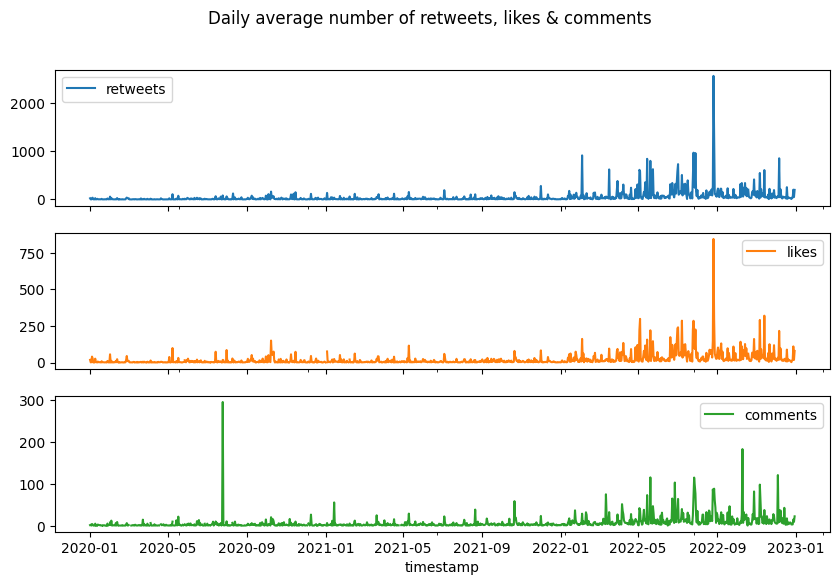

In [166]:
by = [df_prices.timestamp.dt.date]
num_cols = ["retweets", "likes", "comments"]

df_prices.\
    groupby(by)[num_cols].\
    mean().\
    plot(subplots=True, figsize=(10, 6), title="Daily average number of retweets, likes & comments"); 

### Text analysis

#### Frequencies of tokens

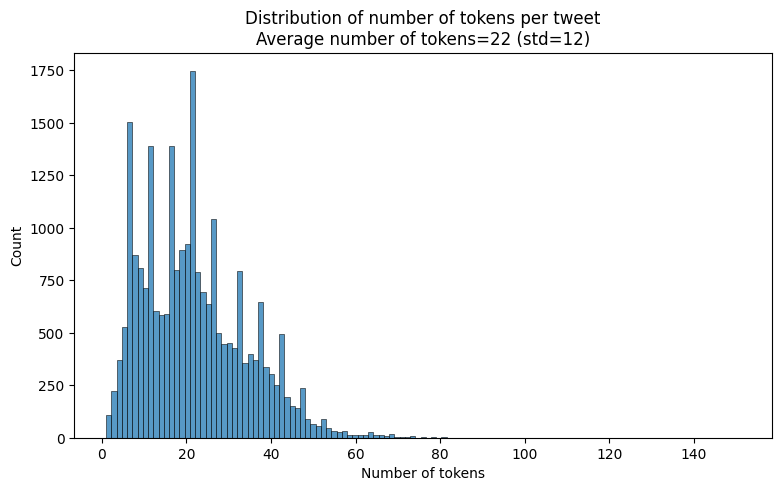

In [167]:
n_tokens_avg = np.mean(df_prices.n_tokens)
n_tokens_std = np.std(df_prices.n_tokens)

fig, ax = plt.subplots(figsize=(9, 5))

sns.histplot(data=df_prices, x="n_tokens", ax=ax)
ax.set_xlabel("Number of tokens")
ax.set_title(f"Distribution of number of tokens per tweet\nAverage number of tokens={round(n_tokens_avg)} (std={round(n_tokens_std)})");  

In [168]:
tokens = list(chain(*df_prices.tokens.values))
n_tokens = len(tokens)

In [169]:
token_counts = Counter(tokens)
top_n = 20

{
    k: round(100 * v / n_tokens, 2) 
    for k, v in dict(token_counts.most_common(top_n)).items()
}

{'inflation': 6.64,
 'prix': 1.1,
 'pas': 1.06,
 'taux': 0.82,
 'hausse': 0.72,
 '1': 0.62,
 '2': 0.61,
 '5': 0.47,
 'france': 0.42,
 '0': 0.41,
 '3': 0.38,
 '4': 0.35,
 'contre': 0.34,
 'économie': 0.33,
 '2021': 0.32,
 'banque': 0.32,
 'face': 0.32,
 'pouvoir': 0.32,
 'mois': 0.31,
 '2022': 0.3}

In [170]:
text = " ".join(tokens)
wordcloud = WordCloud(background_color="white", max_words = 50).generate(text)

c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Py

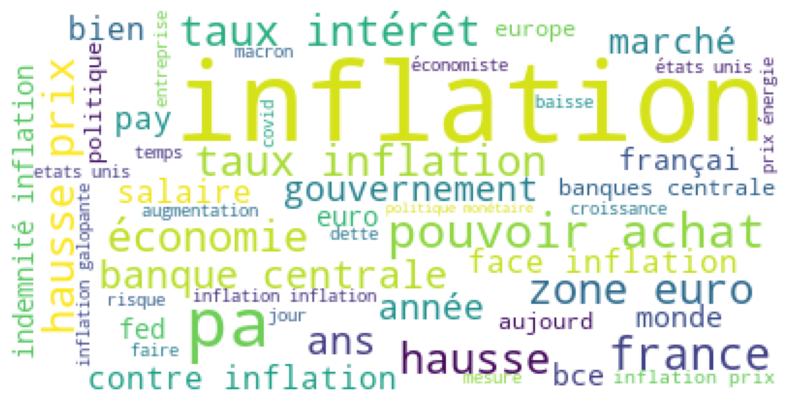

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.imshow(wordcloud)
ax.set_axis_off(); 

#### Topic detection

We use Latent Dirichlet Allocation implemented in the `gensim` library to identify topics in the collection of prices-related tweets (documents). LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

In [172]:
text_data = df_prices.tokens.to_list()

In [173]:
dictionary = corpora.Dictionary(text_data)

In [174]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [175]:
n_topics = 4
ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=n_topics)

In [176]:
ldamodel.print_topics()

[(0,
  '0.058*"inflation" + 0.035*"taux" + 0.023*"prix" + 0.023*"banque" + 0.020*"hausse" + 0.017*"intérêt" + 0.014*"centrale" + 0.012*"2" + 0.011*"5" + 0.011*"1"'),
 (1,
  '0.041*"inflation" + 0.011*"fed" + 0.009*"guerre" + 0.008*"ukraine" + 0.008*"the" + 0.007*"“" + 0.006*"”" + 0.006*"to" + 0.005*"in" + 0.005*"of"'),
 (2,
  '0.066*"inflation" + 0.013*"pas" + 0.012*"prix" + 0.008*"face" + 0.006*"hausse" + 0.006*"contre" + 0.006*"faire" + 0.006*"france" + 0.006*"économie" + 0.005*"crise"'),
 (3,
  '0.044*"inflation" + 0.015*"pouvoir" + 0.015*"achat" + 0.015*"pas" + 0.014*"salaires" + 0.010*"€" + 0.010*"français" + 0.009*"gouvernement" + 0.008*"macron" + 0.008*"euros"')]

Let’s visualize the topics for interpretability using the `pyLDAvis` library which is designed to give: 
- a better understanding and interpretation of individual topics (most frequent and/or relevant terms per topic)
- a better understanding of the relationships between them (intertopic distance plot)

Note: you can download the `.html` file [here](./figs/lda_4_topics.html) to have better display.

In [177]:
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [179]:
pyLDAvis.save_html(lda_display, "../figs/lda_"+ str(n_topics)+"_topics.html")

## Daily number of tweets related to prices/inflation

## Sentiment analysis